Visualize the correlators in th UV coordinates. There is the option to look for U-U correlations (outgoing null direction, keep V fixed), and for V-V correlators (keep u fixed). You need to first run the postprocessing tool "calculate_correlators_UV.jl" for the same NU, NV. By default the V-V correlators are commented out.

You need a semiclassical simulation (with or without backreaction) and store "data" and "quantum", at the same timesteps.

In [1]:
# load packages
using HDF5
using LaTeXStrings
using Plots ; pythonplot()
using DelimitedFiles
using SpheriCo

┌ Warning: backend `PythonPlot` is not installed.
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/backends.jl:43


In [2]:
# give the directory where the data from all the runs are saved
dir = "../examples/quantum_runs/"
par = "a1.25_b0.0_c1.0_rmax30.0_tmax10.0_cfl0.0625_sigma0.02_overMp2_0.9988967160535545_reg_true_backreact_true_rcut20.0_mPV1.0_dk_denom_30_kmax20.0_lmax60.0"
your_dir = dir*par

# check if the UV domain (a bit further down) looks ok with that many points
NU = 400 # index i, labels rows, where mat[i,j] is a matrix
NV = 300; # index j, labels columns, where mat[i,j] is a matrix

In [3]:
# set number of radial grid points
D = 3
Nr = 128*2^D + 3 # the overal course graining

# make directory to save figures
out_dir = "./correlators_UV/"*par*"/resol_D$(D)"
if ispath(out_dir)==false
    mkpath(out_dir)
end

# load the r grid
r = h5read(your_dir*"/data_$(Nr)/r.h5","r")
dr = r[2] - r[1]

# list all available iterations (and corresponding files)
(its, all_filenames) = list_h5_files(your_dir*"/data_$(Nr)", prefix="data_");

# you first need to run "calculate_correlators_UV.jl" with the same NU, NV.
UU_crlt = h5read(your_dir*"/data_$(Nr)/UU_crlt_NU$(NU).h5","crlt")
#VV_crlt = h5read(your_dir*"/data_$(Nr)/VV_crlt_NV$(NV).h5","crlt")

# print list of data
println("length(its) = ",length(its))
println("its: ",its)

length(its) = 72
its: [0, 64, 128, 192, 256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536, 1600, 1664, 1728, 1792, 1856, 1920, 1984, 2048, 2112, 2176, 2240, 2304, 2368, 2432, 2496, 2560, 2624, 2688, 2752, 2816, 2880, 2944, 3008, 3072, 3136, 3200, 3264, 3328, 3392, 3456, 3520, 3584, 3648, 3712, 3776, 3840, 3904, 3968, 4032, 4096, 4160, 4224, 4288, 4352, 4416, 4480, 4544]


Store various quantities in (t,r) coordinates. Needed to transfor to double null (U,V) coordinates.

In [7]:
ti_max = 69#length(its)

U_tr = zeros(ti_max, length(r));
V_tr = zeros(ti_max, length(r));
f_tr = zeros(ti_max, length(r));
g_tr = zeros(ti_max, length(r));

Φ_tr = zeros(ti_max, length(r));

α_tr  = zeros(ti_max, length(r));
A_tr  = zeros(ti_max, length(r));
B_tr  = zeros(ti_max, length(r));
KB_tr = zeros(ti_max, length(r));

for i in 1:ti_max
    it = its[i]
    it_str  = lpad(it, 4, "0")

    #v_classic_labels = ["Φ", "Π", "Ψ", "A", "B", "DB", "Utld", "K", "KB", "λ", "α", "Dα", "Θ", "Zr", "f", "g", "U", "V"]
    U   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,17]
    V   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,18]
    f   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,15]
    g   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,16]
    Φ   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,1]
    α   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,11]
    A   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,4]
    B   =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,5]
    KB  =  h5read(your_dir*"/data_$(Nr)/data_$(it_str).h5","v")[:,9]

    U_tr[i,:] = U
    V_tr[i,:] = V
    f_tr[i,:] = f
    g_tr[i,:] = g
    Φ_tr[i,:] = Φ
    α_tr[i,:]  = α
    A_tr[i,:]  = A
    B_tr[i,:]  = B
    KB_tr[i,:] = KB

end

dtdU_tr = 0.5./(α_tr.*f_tr);
drdU_tr = - 0.5./sqrt.(A_tr.*f_tr); # sometimes the quantity under sqrt is negative (problem).
# You can check where, uncommenting the cell below.

# set manually: 64 is how often (in iterations) we saved data, and 16 is from the CFL
dt = 64*dr/16
tlist = zeros(ti_max) # time list
AH_t  = zeros(ti_max) # apparent horizon radius, in simulation time
for i in 1:ti_max-1
    tlist[i+1] = tlist[i]+dt
    AH_t[i] = find_AH(r, B_tr[i,:], A_tr[i,:], KB_tr[i,:])
end
AH_t[end] = find_AH(r, B_tr[end,:], A_tr[end,:], KB_tr[end,:]);
#println(tlist)
#println(AH_t)

In [5]:
# for i in 1:ti_max
#    for j in 1:Nr
#        if (A_tr.*f_tr)[i,j] <0
#            println("(i,j) = ", (i,j))
#        end
#    end
# end

(i,j) = (70, 28)
(i,j) = (71, 28)
(i,j) = (72, 26)
(i,j) = (72, 28)


Get the apparent horizon position in (t,r):

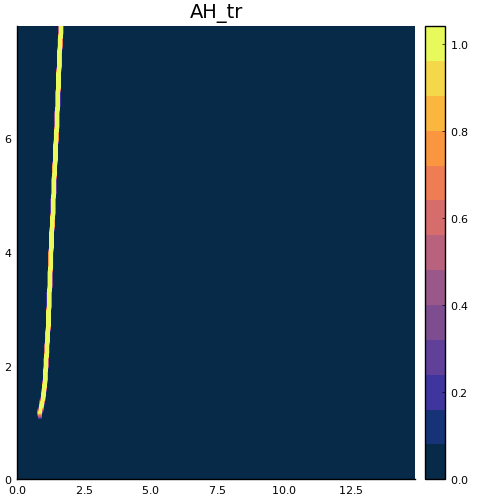

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [8]:
AH_tr = zeros(ti_max, length(r));
for i in 1:ti_max
    for j in 3:length(r)-1
        if (r[j]+r[j+1])/2 - AH_t[i] ≈ 0
            AH_tr[i,j] = 1
            AH_tr[i,j-1] = 1
            AH_tr[i,j-2] = 1
            AH_tr[i,j+1] = 1
            AH_tr[i,j+2] = 1
        end
    end
end

contourf(r[3:512], tlist, AH_tr[:,3:512],
color=:thermal,
wsize = (500,500),title = "AH_tr")

Plot U and V coordinates against (t,r). 

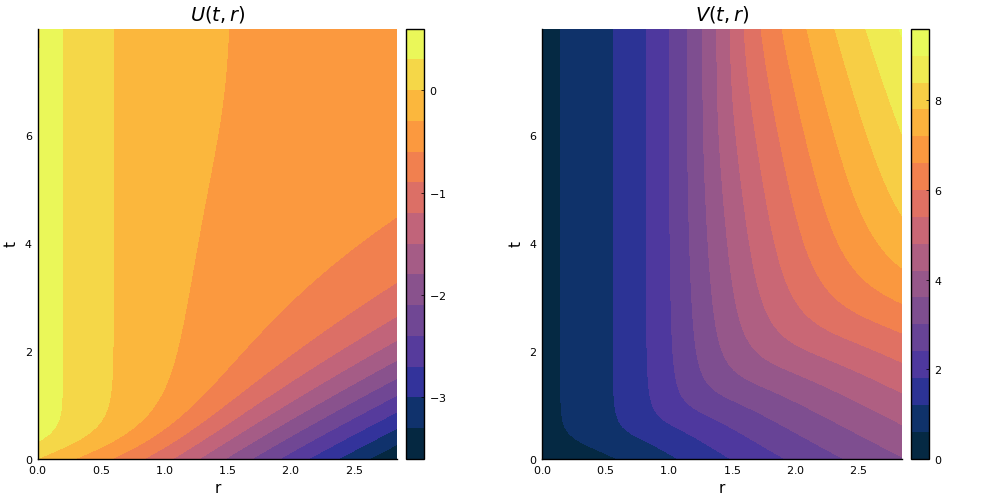

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [9]:
p1 = contourf(r[3:100], tlist, U_tr[:,3:100],
color=:thermal,
wsize = (500,500),title = L"U(t,r)", ylabel = "t", xlabel="r")

p2 = contourf(r[3:100], tlist, V_tr[:,3:100],
color=:thermal,
wsize = (500,500),title = L"V(t,r)", ylabel = "t", xlabel="r")


plot(p1, p2, layout = (1, 2), legend = false, wsize = (1000,500) )


The algorithm to go form (t,r) to (U,V) involves the two cells below. First, setting up some necessary quantities, and initiating some arrays to save data in (U,V) coordinates.

In [10]:
#take min max of U(t,r), and V(t,r)
Umin = minimum(U_tr)
Umax = maximum(U_tr)
Vmin = minimum(V_tr)
Vmax = maximum(V_tr)

U_axis = zeros(NU)
for i in 1:NU
    U_axis[i] = Umin + (i-1)*(Umax - Umin)/(NU-1)
end

V_axis = zeros(NV)
for j in 1:NV
    V_axis[j] = Vmin + (j-1)*(Vmax - Vmin)/(NV-1)
end

dom      = NaN* zeros(NU,NV)
AH_UV    = NaN* zeros(NU,NV)
Φ_UV     = NaN* zeros(NU,NV)

Umin = minimum(U_tr)
Umax = maximum(U_tr)
Vmin = minimum(V_tr)
Vmax = maximum(V_tr)
#println(Umin)
#println(Umax)
#println(Vmin)
#println(Vmax)

dU = (Umax - Umin)/(NU-1)
#println(dU)
dV = (Vmax - Vmin)/(NV-1);
#println(dV)


Check if the UV cell and the tr cell have overlap, and if yes, copy the tr data to UV. 
(more details on thi algorithm, in the paper)

In [11]:
# new
for i in 1:ti_max#length(tlist)
    for j in 1:length(r)
        Utr     = U_tr[i,j]
        Vtr     = V_tr[i,j]
        Φtr     = Φ_tr[i,j]
        AHtr    = AH_tr[i,j]
        
        idown  = Int( round( 1 + (NU - 1)*(Utr - Umin)/(Umax - Umin) ) )
        jleft  = Int( round( 1 + (NV - 1)*(Vtr - Vmin)/(Vmax - Vmin) ) )

        if jleft < NV
            jright = jleft + 1
        else
            jright = jleft
        end
        if idown < NU
            iup =  idown + 1
        else
            iup =  idown
        end
        #println("iup=",iup)
        #println("idown=",idown)
        #println("jleft=",jleft)
        #println("jright=",jright)

        dom[idown, jleft]  = 1
        dom[iup, jleft]    = 1
        dom[idown, jright] = 1
        dom[iup, jright]   = 1
        
        Φ_UV[idown, jleft]  = Φtr
        Φ_UV[iup, jleft]    = Φtr
        Φ_UV[idown, jright] = Φtr
        Φ_UV[iup, jright]   = Φtr
   
        AH_UV[idown, jleft]  = AHtr
        AH_UV[iup, jleft]    = AHtr
        AH_UV[idown, jright] = AHtr
        AH_UV[iup, jright]   = AHtr

    end
end


The simulation domain in UV coordinates. If you use too few or too many NU, NV points, it might look bad. Adjust if needed.

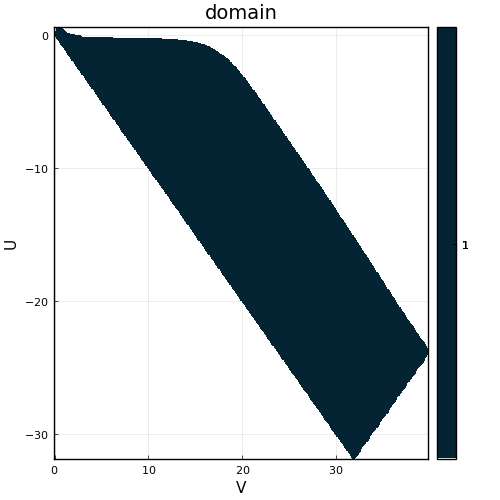

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [12]:
contourf(V_axis, U_axis, dom[:,:],
    xlabel = "V",
    ylabel = "U",
    color=:thermal,
    wsize = (500,500),title = "domain", frame=true)

The position of the apparent horizon, in UV.

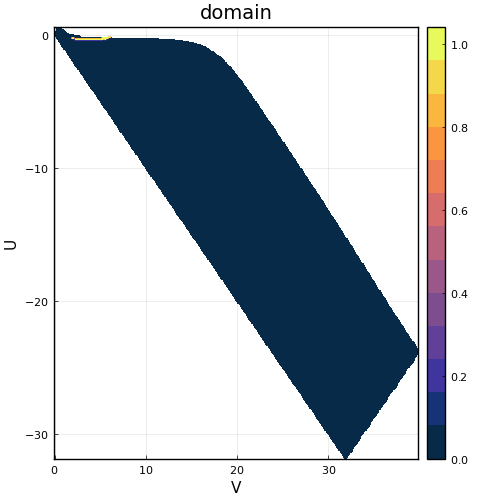

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
contourf(V_axis, U_axis, AH_UV,
    xlabel = "V",
    ylabel = "U",
    color=:thermal,
    wsize = (500,500),title = "domain", frame=true)


Store the apparent horizon in U,V, as lists. Useful for later.

In [14]:
AH_U = [];
AH_V = [];
for i in 1:NU
    for j in 1:NV
        if AH_UV[i,j]==1
            append!(AH_U, U_axis[i])
            append!(AH_V, V_axis[j])
        end
    end
end
#println(AH_U)
#println(AH_V)

In [15]:
# scan the lists and place AH_V in increasing number; and follow the same flipts in AH_U
test=true
while test==true
    for i in 2:length(AH_V)
        if AH_V[i] < AH_V[i-1]
            temp1 = AH_V[i-1]
            AH_V[i-1] = AH_V[i]
            AH_V[i] = temp1
            temp2 = AH_U[i-1]
            AH_U[i-1] = AH_U[i]
            AH_U[i] = temp2
        end
    end
    j = 2
    while AH_V[j] >= AH_V[j-1] && j<length(AH_V)
        j+=1
        #println(j)
    end
    if j==length(AH_V)
        test = false
        #println(test)
    end
    #println("end of permutation")
end

#println(AH_U)
#println(AH_V)

The loop below inspects the location of AH in U,V. It might oscillate, but this is probably an artifact of postprocessing (and lack or resolution).

In [16]:
for i in 1:length(AH_V)
    println("i, V, U = ", (i, AH_V[i], AH_U[i]))
end

i, V, U = (1, 1.9416843934215908, -0.26660213876992245)
i, V, U = (2, 2.075036281232603, -0.26660213876992245)
i, V, U = (3, 2.3417400568546265, -0.3477643396559422)
i, V, U = (4, 2.475091944665638, -0.3477643396559422)
i, V, U = (5, 2.60844383247665, -0.3477643396559422)
i, V, U = (6, 2.7417957202876617, -0.3477643396559422)
i, V, U = (7, 2.8751476080986738, -0.3477643396559422)
i, V, U = (8, 3.008499495909686, -0.3477643396559422)
i, V, U = (9, 3.1418513837206974, -0.3477643396559422)
i, V, U = (10, 3.275203271531709, -0.3477643396559422)
i, V, U = (11, 3.4085551593427215, -0.3477643396559422)
i, V, U = (12, 3.5419070471537326, -0.3477643396559422)
i, V, U = (13, 3.675258934964744, -0.3477643396559422)
i, V, U = (14, 3.8086108227757567, -0.3477643396559422)
i, V, U = (15, 3.941962710586768, -0.3477643396559422)
i, V, U = (16, 4.07531459839778, -0.3477643396559422)
i, V, U = (17, 4.2086664862087915, -0.3477643396559422)
i, V, U = (18, 4.342018374019803, -0.3477643396559422)
i, V, U = 

Plot the scalar field that drives the collapse, in (U,V). It helps to understand what type of correlators we are looking for. In the example below, the vertical black line is a possible slice in which we inspect the U-U correlator.

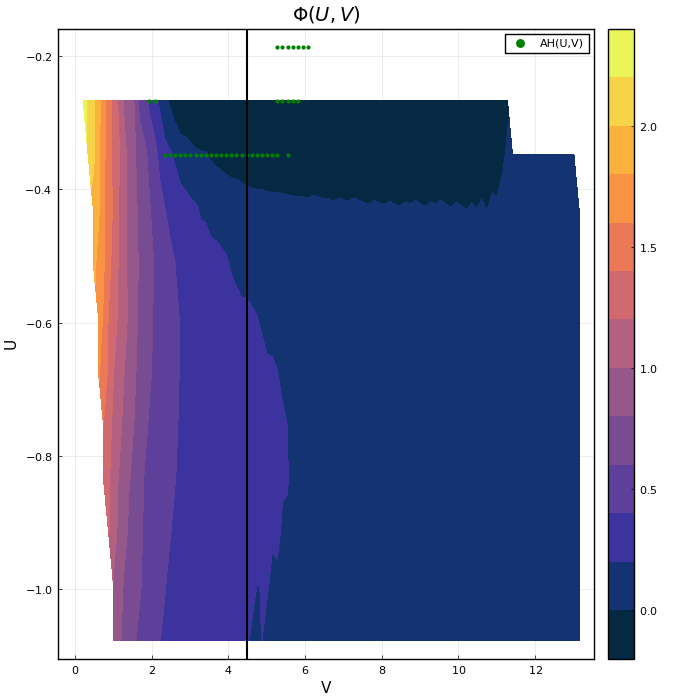

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [20]:
# set manually the NU, NV reange you want to plot, below
ui = 380
uj = 390
vi = 1
vj = 100

p = contourf(V_axis[vi:vj], U_axis[ui:uj], (Φ_UV[ui:uj,vi:vj]),
        xlabel = "V",
        ylabel = "U",
        color=:thermal,
        wsize = (700,700),title = L"\Phi(U,V)",
        frame =true)
p = scatter!((AH_V, AH_U),label="AH(U,V)", markerstrokewidth=0, mc=:green, ms=3)

p = plot!([V_axis[35]], seriestype="vline", label="", linewidth=1.5, color = "black")

# uncomment if you want to save fig
#savefig(p, out_dir*"/Phi_UV.pdf")

U-U correlators:

In [42]:
# this is the index we slice in V_axis
vi  = 35

# these are the first and last points we plot in u_axis
i = 360
j = 391

# set this manually, it has to be the one (or more than one due to numerical error) index that corresponds to the slice we chose
findall(x->x == V_axis[vi], AH_V)

1-element Vector{Int64}:
 19

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


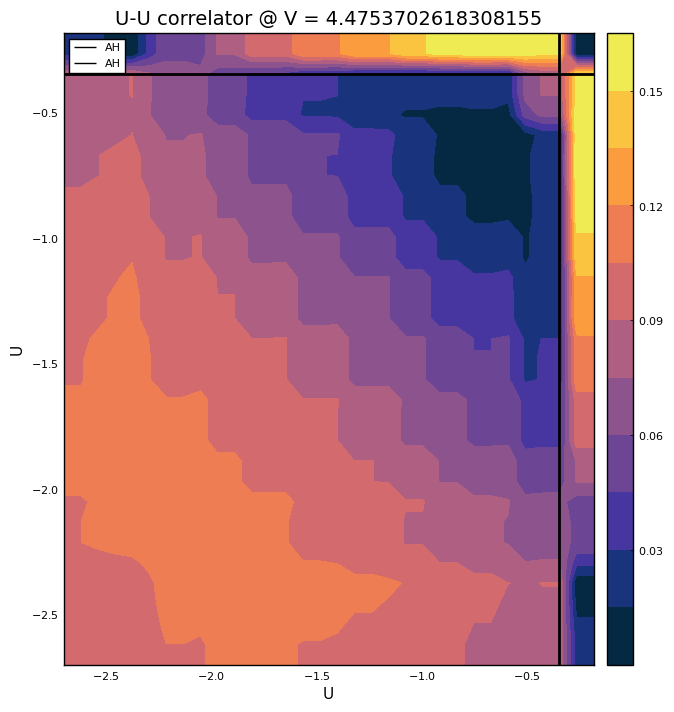

"/home/thanasis/repos/SpheriCo.jl/tools/correlators_UV/a1.25_b0.0_c1.0_rmax30.0_tmax10.0_cfl0.0625_sigma0.02_overMp2_0.9988967160535545_reg_true_backreact_true_rcut20.0_mPV1.0_dk_denom_30_kmax20.0_lmax60.0/resol_D3/UU_crlt_V_4.4753702618308155.pdf"

In [61]:
# check the output of the cell above
ah_vi = 19

contourf(U_axis[i:j], U_axis[i:j], real.(UU_crlt[vi,i:j,i:j]),
    title="U-U correlator @ V = $(V_axis[vi])",
    xlabel = "U",
    ylabel = "U",
    color=:thermal,
    wsize = (700,700),
    frame=true)

plot!([AH_U[ah_vi]], seriestype="vline", label="AH", linewidth=2, color = "black")
p = plot!([AH_U[ah_vi]], seriestype="hline", label="AH", linewidth=2, color = "black", legend=:topleft)
#ui = 387
#p = plot!([U_axis[ui]], seriestype="hline", label="U = $(U_axis[ui])", linewidth=3, color = "red")
# uncomment if you want to save fig
savefig(p, out_dir*"/UU_crlt_V_$(AH_V[ah_vi]).pdf")

In [48]:
U_axis[370:388]
U_axis[390]

-0.26660213876992245

V-V correlators, below (uncomment). Remember that the horizon is an outgoing null hypersurface (that is a hypersurface of fixed V, in theory). 

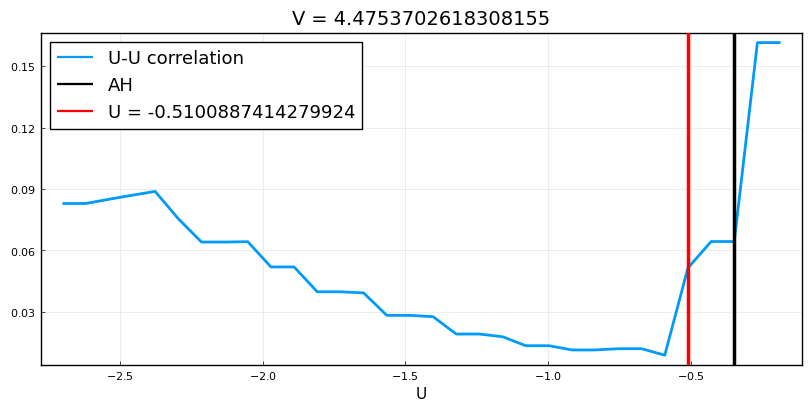

"/home/thanasis/repos/SpheriCo.jl/tools/correlators_UV/a1.25_b0.0_c1.0_rmax30.0_tmax10.0_cfl0.0625_sigma0.02_overMp2_0.9988967160535545_reg_true_backreact_true_rcut20.0_mPV1.0_dk_denom_30_kmax20.0_lmax60.0/resol_D3/UU_crlt_U_-0.5100887414279924_V_4.4753702618308155.pdf"

In [62]:
ui = 387
plot(U_axis[i:j],  real.(UU_crlt[vi,ui,i:j]),
    title="V = $(V_axis[vi])",
    xlabel = "U",
    #ylabel = "U-U correlation",
    wsize = (800,400),
    frame=true,
    linewidth = 2, legendfontsize=13,
    label = "U-U correlation")

plot!([AH_U[ah_vi]], seriestype="vline", label="AH", linewidth=2.5, color = "black", legendfontsize=13)
p = plot!([U_axis[ui]], seriestype="vline", label="U = $(U_axis[ui])", linewidth=2.5, color = "red", legend=:topleft, legendfontsize=13)


# uncomment if you want to save fig
savefig(p, out_dir*"/UU_crlt_U_$(U_axis[ui])_V_$(AH_V[ah_vi]).pdf")

In [ ]:
## this is the index we slice in V_axis
#ui  = 100
## these are the first and last points we plot in u_axis
#i = 160
#j = 240
## set this manually, it has to be the one (or more than one due to numerical error) index that corresponds to teh slice we chose
#findall(x->x == U_axis[ui], AH_U)

In [ ]:
## check the output of the cell above
#ah_ui = 1

#contourf(V_axis[i:j], V_axis[i:j], real.(VV_crlt[ui,i:j,i:j]),
#    title="V-V correlator @ U = $(U_axis[ui])",
#    xlabel = "V",
#    ylabel = "V",
#    color=:thermal,
#    wsize = (500,500))

#plot!([AH_V[ah_ui]], seriestype="vline", label="AH", linewidth=3, color = "black")
#plot!([AH_V[ah_ui]], seriestype="hline", label="AH", linewidth=3, color = "black")